# Installs

In [ ]:
!pip install structure_tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for structure-tensor: filename=structure_tensor-0.2.0-py3-none-any.whl size=15924 sha256=00bdafa1a1eb25fca827bca4eac7637c658c64585500e8015e8a9b06c731d7b3
  Stored in directory: /root/.cache/pip/wheels/91/20/c3/7f70390148b5bd4ca9efcdd82ba1c678e7d26194a1c4d9401d
Successfully built structure-tensor


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image, ImageReadMode
import numpy as np
from structure_tensor import eig_special_2d, structure_tensor_2d, eig_special_3d, structure_tensor_3d
import torch.nn.functional as F
import skimage.io 
import matplotlib.pyplot as plt
import scipy as scp
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import torch.optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/AndersRolighed/02461_January_project

In [ ]:
!pip install structure-tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# DataLoader

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))-4

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"img_{idx}.jpeg")
        image = skimage.io.imread(img_path, as_gray = True)

        if self.transform:
          x, y = self.transform(image)
        return x, y

class Transform_structure(object):

    def __call__(self, img):
      scale = 0.25
      rho = 8
      sigma = rho/2
      downsampled_img = scp.ndimage.zoom(img, scale)
      downsampled_S = structure_tensor_2d(downsampled_img, sigma, rho)
      downsampled_val, downsampled_vec = eig_special_2d(downsampled_S)
      downsampled_vec = torch.from_numpy(downsampled_vec)

      transformed_structure_tensor = F.interpolate(downsampled_vec, 400)
      transformed_structure_tensor = transformed_structure_tensor.permute(0, 2, 1)
      transformed_structure_tensor = F.interpolate(transformed_structure_tensor, size=400)
      # transformed_structure_tensor = transformed_structure_tensor.permute(1, 2, 0)

      S = structure_tensor_2d(img, sigma, rho)
      val, vec = eig_special_2d(S)
      # vec = torch.from_numpy(vec).permute(1,2,0)

      img = np.reshape(img, (1, 400, 400))
      img = torch.from_numpy(img)
      input_img = torch.cat((img, transformed_structure_tensor), 0)
      return input_img, vec

In [ ]:
transformed_dataset = CustomImageDataset(img_dir="/content/drive/MyDrive/Deep Learning/trainingimages/", 
                             transform=Transform_structure())

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=1,
                        shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([400, 400])


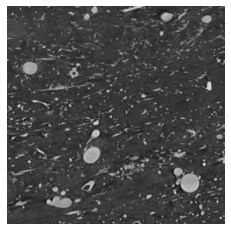

torch.Size([400, 400])


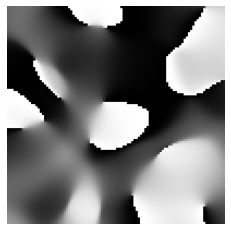

torch.Size([400, 400])


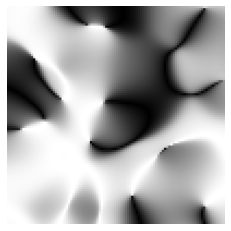

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
  for j in range(3):
    show_img = sample_batched[0][0]
    show_img = show_img[:,:,j]
    print(show_img.shape)
    plt.figure()
    plt.imshow(show_img, cmap="gray")
    plt.axis('off')
    plt.ioff()
    plt.show()
  break

# U-net

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan  2 14:21:19 2022


Credit for double_convolution fuction to Abhishek Thakur
https://www.youtube.com/watch?v=u1loyDCoGbE

"""

#%% Import

import numpy as np
import torch
import torch.nn as nn

#%% Functions

# input_conv og output_conv er integers som angiver dimensionen af hhv. input og output
def double_convolution(input_conv, output_conv):
    convolution = nn.Sequential(
        nn.Conv2d(input_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        )
    return convolution

#%% Class

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.down_conv_1 = double_convolution(3, 16)
        self.down_conv_2 = double_convolution(16, 32)
        self.down_conv_3 = double_convolution(32, 64)
        self.down_conv_4 = double_convolution(64, 128)
        self.down_conv_5 = double_convolution(128, 256)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.up_trans_5 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2)
        
        self.up_conv_1 = double_convolution(256, 128)
        self.up_conv_2 = double_convolution(128, 64)
        self.up_conv_3 = double_convolution(64, 32)
        self.up_conv_4 = double_convolution(32, 16)
        
        self.out = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1)

    def forward(self, input_data):
        # Encoder 
        x1 = self.down_conv_1(input_data)
        print(x1.shape)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        print(x3.shape)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        print(x5.shape)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)
        print(x7.shape)
        x8 = self.max_pool(x7)
        x9 = self.down_conv_5(x8)
        print(x9.shape)
        
        # Decoder which concatenates from the encoder layers
        y = self.up_trans_1(x9)
        y = self.up_conv_1(torch.cat([y,x7], 1))
        y = self.up_trans_2(y)
        print(y.shape)
        y = self.up_conv_2(torch.cat([y,x5], 1))
        y = self.up_trans_3(y)
        y = self.up_conv_3(torch.cat([y,x3], 1))
        y = self.up_trans_4(y)
        y = self.up_conv_4(torch.cat([y,x1], 1))

        # Apply final conv2d layer and sigmoid        
        y = self.out(y)
        y_out = torch.sigmoid(y)

        return y_out
    


In [ ]:
def train_epochs(NETWORK, NUM_EPOCHS, BATCH_SIZE, LEARN_RATE):
    network = NETWORK
    network = network.float()
    
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    # print(f"Using {device} device")

    # Set model to test - ie. train=false
    # model.train(mode=False)
    
    transformed_dataset = CustomImageDataset(img_dir="/content/drive/MyDrive/Deep Learning/trainingimages/", 
                             transform=Transform_structure())
    
    dataloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                        shuffle=True)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=LEARN_RATE)
    # loss_func = torch.nn.CrossEntropyLoss()
    loss_func = torch.nn.MSELoss()
    # loss_func = DiceBCELoss()
    # loss_func = DiceLoss()
    
    all_loss = []
    
    for epoch in range(NUM_EPOCHS):
    
        epoch_loss = []
    
        for idx, (images, labels) in enumerate(dataloader): # Get Batch
            # Send to device
            # images, labels = images.to(device), labels.to(device)
        
            preds = network(images.float()) # Pass Batch
            # loss = F.cross_entropy(preds, labels) # Calculate Loss
            loss = loss_func(preds, labels.float())
    
            optimizer.zero_grad()
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights
            
            run_loss = 0.
            run_loss = loss.item()
            epoch_loss.append(run_loss)
            
            # Diagnostics
            print(f"{idx}: {run_loss}")
            
            
        # print(
        #     "epoch", epoch, 
        #     # "total_correct:", total_correct, 
        #     "loss:", total_loss
        # )
        all_loss.append(epoch_loss)
         
    
    return network, all_loss

0: 0.41013047099113464
1: 0.37403157353401184
2: 0.3949081599712372
3: 0.40776485204696655
4: 0.40538090467453003
5: 0.4159125089645386
6: 0.3859042823314667
7: 0.3952093720436096
8: 0.35234469175338745
9: 0.35702550411224365
10: 0.32297348976135254
11: 0.25469711422920227
12: 0.3392351567745209
13: 0.2961067259311676
14: 0.28806859254837036
15: 0.2802183926105499
16: 0.3079284727573395
17: 0.28244906663894653
18: 0.273733526468277
19: 0.25495487451553345
20: 0.27111661434173584
21: 0.26673510670661926
22: 0.25213468074798584
23: 0.25076884031295776
24: 0.28416576981544495
25: 0.26362374424934387
26: 0.25955930352211
27: 0.2563099265098572
28: 0.24286521971225739
29: 0.2536866068840027
30: 0.2577110826969147
31: 0.23702310025691986
32: 0.2684321999549866
33: 0.2713773846626282
34: 0.2744179964065552
35: 0.24578963220119476
36: 0.2511982321739197
37: 0.2677304446697235
38: 0.26200634241104126
39: 0.27286258339881897
40: 0.2622506320476532
41: 0.2484160214662552
42: 0.2630387544631958
43

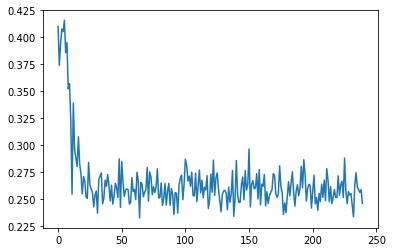

In [ ]:
NETWORK = UNet()
NUM_EPOCHS = 1
BATCH_SIZE = 10
LEARN_RATE = 0.001

network, all_loss = train_epochs(NETWORK, NUM_EPOCHS, BATCH_SIZE, LEARN_RATE)
loss_arr = np.array(all_loss).flatten()

# Save model
# torch.save(network.state_dict(), "model_test.pth")
# print("Saved PyTorch Model State to model.pth")

# Plot
plt.plot([val for val in loss_arr if val < 10.])
plt.show()

In [ ]:

import numpy as np
import torch
# import torch.nn as nn
from torch.nn.functional import normalize
from torch.utils.data import DataLoader


import numpy as np
import torch
import torch.nn as nn

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))-4

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"img_{idx}.jpeg")
        image = skimage.io.imread(img_path, as_gray = True)

        if self.transform:
          x, y = self.transform(image)
        return x, y


class Transform_structure(object):

    def __call__(self, img):
      scale = 0.25
      rho = 8
      sigma = rho/2
      downsampled_img = scp.ndimage.zoom(img, scale)
      downsampled_S = structure_tensor_2d(downsampled_img, sigma, rho)
      downsampled_val, downsampled_vec = eig_special_2d(downsampled_S)
      downsampled_vec = torch.from_numpy(downsampled_vec)

      transformed_structure_tensor = F.interpolate(downsampled_vec, 400)
      transformed_structure_tensor = transformed_structure_tensor.permute(0, 2, 1)
      transformed_structure_tensor = F.interpolate(transformed_structure_tensor, size=400)
      # transformed_structure_tensor = transformed_structure_tensor.permute(1, 2, 0)

      S = structure_tensor_2d(img, sigma, rho)
      val, vec = eig_special_2d(S)
      # vec = torch.from_numpy(vec).permute(1,2,0)

      img = np.reshape(img, (1, 400, 400))
      img = torch.from_numpy(img)
      img = normalize(img)
      input_img = torch.cat((img, transformed_structure_tensor), 0)
      return input_img, vec

#%% Functions


# input_conv og output_conv er integers som angiver dimensionen af hhv. input og output
def double_convolution(input_conv, output_conv):
    convolution = nn.Sequential(
        nn.Conv2d(input_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(output_conv),
        nn.Dropout2d(Drop_P),
        nn.Conv2d(output_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(output_conv),
        )
    return convolution


#%% Class

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_convolution(3, 16)
        self.down_conv_2 = double_convolution(16, 32)
        self.down_conv_3 = double_convolution(32, 64)
        self.down_conv_4 = double_convolution(64, 128)
        self.down_conv_5 = double_convolution(128, 256)

        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.up_trans_5 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2)
        
        self.up_conv_1 = double_convolution(256, 128)
        self.up_conv_2 = double_convolution(128, 64)
        self.up_conv_3 = double_convolution(64, 32)
        self.up_conv_4 = double_convolution(32, 16)
        
        self.out = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1)

    def forward(self, input_data):
        # Encoder 
        x1 = self.down_conv_1(input_data)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool(x7)
        x9 = self.down_conv_5(x8)
        
        # Decoder which concatenates from the encoder layers
        y = self.up_trans_1(x9)
        y = self.up_conv_1(torch.cat([y,x7], 1))
        y = self.up_trans_2(y)
        y = self.up_conv_2(torch.cat([y,x5], 1))
        y = self.up_trans_3(y)
        y = self.up_conv_3(torch.cat([y,x3], 1))
        y = self.up_trans_4(y)
        y = self.up_conv_4(torch.cat([y,x1], 1))

        # Apply final conv3d layer and sigmoid        
        y = self.out(y)
        y_out = torch.sigmoid(y)

        return y_out
    

# Hyperparameters
LOAD_MODEL = False
LOADPATH = "model_hpc_ba2-lr0001-ep100.pth.tar"
SAVEPATH = "model_hpc_ba2-lr0001-ep100.pth.tar"
LOSS_PATH = "loss_array_ba2-lr0001-ep100.npy"

LEARNING_RATE = 0.0001
BATCH_SIZE = 2
NUM_EPOCHS = 100
Drop_P = 0.2


def training():
    # Parameters
    model = UNet()
    out = 0
    y = 0
    
    # Set device, send model to device
    device = "cuda" if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Loss function
    loss_func = torch.nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Dataload
    transformed_dataset = CustomImageDataset(img_dir="/content/drive/MyDrive/Deep Learning/trainingimages/", 
                             transform=Transform_structure())
    
    dataloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                        shuffle=True)

    # Load model after model and optimizer initialization
    if LOAD_MODEL:
        checkpoint = torch.load(LOADPATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_nr = checkpoint['epoch']
        loss = checkpoint['loss']
        total_loss = checkpoint['total_loss']
        loss_pr_epoch = checkpoint['loss_pr_epoch']
        
        # print("Model's state_dict:")
        # for param_tensor in model.state_dict():
        #     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
        print(f"Loaded model: {LOADPATH}")
        
    else:
        epoch_nr = 1
        total_loss = []
        loss_pr_epoch = []

    # Training mode initialized
    model.train()

    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_loss = []
        for i, (feature, y) in enumerate(dataloader):
            # Dataload. Send to device. 
            feature, y = feature.float(), y.float()
            feature, y = feature.to(device), y.to(device)
            
            # Data to model
            out = model(feature)
            
            # Calculate loss, do backpropagation and step optimizer
            loss = loss_func(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save loss
            loss_np = loss.detach().cpu()
            loss_np = loss_np.numpy()
            total_loss.append(loss_np)
            epoch_loss.append(loss_np)
            
            # Print loss
            print(f"Epoch {epoch_nr}, batch {i}: loss = {float(loss)}")
            
        # Save average loss for each epoch
        epoch_loss = np.mean(epoch_loss)
        loss_pr_epoch.append(epoch_loss)
        print(f"Loss for epoch {epoch_nr}: {epoch_loss}")
        
        # Epoch counter
        epoch_nr += 1
        
        # Save model at 100 and 200 epochs
        if epoch == 30:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch_nr,
                'loss': loss,
                'total_loss': total_loss,
                'loss_pr_epoch': loss_pr_epoch
                }, "model_hpc_ba2-lr0001-ep30of100.pth.tar")            
        if epoch == 60:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch_nr,
                'loss': loss,
                'total_loss': total_loss,
                'loss_pr_epoch': loss_pr_epoch
                }, "model_hpc_ba2-lr0001-ep60of100.pth.tar")
        
        
    # Save the model in the end
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch_nr,
        'loss': loss,
        'total_loss': total_loss,
        'loss_pr_epoch': loss_pr_epoch
        }, SAVEPATH)

    # Save array of loss
    loss_arr = np.array(total_loss)
    np.save(LOSS_PATH, loss_arr)

    return


if __name__ == "__main__":
    training()
    
    print("-"*40)
    print("All Done")

Epoch 1, batch 0: loss = 0.4515436887741089
Epoch 1, batch 1: loss = 0.42558300495147705
Epoch 1, batch 2: loss = 0.4494721293449402
Epoch 1, batch 3: loss = 0.4476046860218048
Epoch 1, batch 4: loss = 0.43683061003685
Epoch 1, batch 5: loss = 0.4383073151111603
Epoch 1, batch 6: loss = 0.45391562581062317
Epoch 1, batch 7: loss = 0.44409266114234924
Epoch 1, batch 8: loss = 0.49525386095046997
Epoch 1, batch 9: loss = 0.4386991560459137
Epoch 1, batch 10: loss = 0.46439433097839355


KeyboardInterrupt: ignored

In [ ]:

import numpy as np
import torch
# import torch.nn as nn
from torch.nn.functional import normalize
from torch.utils.data import DataLoader


import numpy as np
import torch
import torch.nn as nn

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))-4

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"img_{idx}.jpeg")
        image = skimage.io.imread(img_path, as_gray = True)

        if self.transform:
          x, y = self.transform(image)
        return x, y


class Transform_structure(object):

    def __call__(self, img):
      scale = 0.25
      rho = 8
      sigma = rho/2
      downsampled_img = scp.ndimage.zoom(img, scale)
      downsampled_S = structure_tensor_2d(downsampled_img, sigma, rho)
      downsampled_val, downsampled_vec = eig_special_2d(downsampled_S)
      downsampled_vec = torch.from_numpy(downsampled_vec)

      transformed_structure_tensor = F.interpolate(downsampled_vec, 400)
      transformed_structure_tensor = transformed_structure_tensor.permute(0, 2, 1)
      transformed_structure_tensor = F.interpolate(transformed_structure_tensor, size=400)
      # transformed_structure_tensor = transformed_structure_tensor.permute(1, 2, 0)

      S = structure_tensor_2d(img, sigma, rho)
      val, vec = eig_special_2d(S)
      # vec = torch.from_numpy(vec).permute(1,2,0)

      img = np.reshape(img, (1, 400, 400))
      img = torch.from_numpy(img)
      img = normalize(img)
      input_img = torch.cat((img, transformed_structure_tensor), 0)
      return input_img, vec

#%% Functions


# input_conv og output_conv er integers som angiver dimensionen af hhv. input og output
def double_convolution(input_conv, output_conv):
    convolution = nn.Sequential(
        nn.Conv2d(input_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(output_conv),
        nn.Dropout2d(Drop_P),
        nn.Conv2d(output_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(output_conv),
        )
    return convolution


#%% Class

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_convolution(3, 16)
        self.down_conv_2 = double_convolution(16, 32)
        self.down_conv_3 = double_convolution(32, 64)
        self.down_conv_4 = double_convolution(64, 128)
        self.down_conv_5 = double_convolution(128, 256)

        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.up_trans_5 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2)
        
        self.up_conv_1 = double_convolution(256, 128)
        self.up_conv_2 = double_convolution(128, 64)
        self.up_conv_3 = double_convolution(64, 32)
        self.up_conv_4 = double_convolution(32, 16)
        
        self.out = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1)

    def forward(self, input_data):
        # Encoder 
        x1 = self.down_conv_1(input_data)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool(x7)
        x9 = self.down_conv_5(x8)
        
        # Decoder which concatenates from the encoder layers
        y = self.up_trans_1(x9)
        y = self.up_conv_1(torch.cat([y,x7], 1))
        y = self.up_trans_2(y)
        y = self.up_conv_2(torch.cat([y,x5], 1))
        y = self.up_trans_3(y)
        y = self.up_conv_3(torch.cat([y,x3], 1))
        y = self.up_trans_4(y)
        y = self.up_conv_4(torch.cat([y,x1], 1))

        # Apply final conv3d layer and sigmoid        
        y = self.out(y)
        y_out = torch.sigmoid(y)

        return y_out
    

# Hyperparameters
LOAD_MODEL = False
LOADPATH = "model_hpc_ba2-lr0001-ep100.pth.tar"
SAVEPATH = "model_hpc_ba2-lr0001-ep100.pth.tar"
LOSS_PATH = "loss_array_ba2-lr0001-ep100.npy"

LEARNING_RATE = 0.0001
BATCH_SIZE = 2
NUM_EPOCHS = 100
Drop_P = 0.2


def training():
    # Parameters
    model = UNet()
    out = 0
    y = 0
    
    # Set device, send model to device
    device = "cuda" if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Loss function
    loss_func = torch.nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Dataload
    transformed_dataset = CustomImageDataset(img_dir="/content/drive/MyDrive/Deep Learning/trainingimages/", 
                             transform=Transform_structure())
    
    dataloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                        shuffle=True)

    # Load model after model and optimizer initialization
    if LOAD_MODEL:
        checkpoint = torch.load(LOADPATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_nr = checkpoint['epoch']
        loss = checkpoint['loss']
        total_loss = checkpoint['total_loss']
        loss_pr_epoch = checkpoint['loss_pr_epoch']
        
        # print("Model's state_dict:")
        # for param_tensor in model.state_dict():
        #     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
        print(f"Loaded model: {LOADPATH}")
        
    else:
        epoch_nr = 1
        total_loss = []
        loss_pr_epoch = []

    # Training mode initialized
    model.train()

    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_loss = []
        for i, (feature, y) in enumerate(dataloader):
            # Dataload. Send to device. 
            feature, y = feature.float(), y.float()
            feature, y = feature.to(device), y.to(device)
            
            # Data to model
            out = model(feature)
            
            # Calculate loss, do backpropagation and step optimizer
            loss = loss_func(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save loss
            loss_np = loss.detach().cpu()
            loss_np = loss_np.numpy()
            total_loss.append(loss_np)
            epoch_loss.append(loss_np)
            
            # Print loss
            print(f"Epoch {epoch_nr}, batch {i}: loss = {float(loss)}")
            
        # Save average loss for each epoch
        epoch_loss = np.mean(epoch_loss)
        loss_pr_epoch.append(epoch_loss)
        print(f"Loss for epoch {epoch_nr}: {epoch_loss}")
        
        # Epoch counter
        epoch_nr += 1
        
        # Save model at 100 and 200 epochs
        if epoch == 30:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch_nr,
                'loss': loss,
                'total_loss': total_loss,
                'loss_pr_epoch': loss_pr_epoch
                }, "model_hpc_ba2-lr0001-ep30of100.pth.tar")            
        if epoch == 60:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch_nr,
                'loss': loss,
                'total_loss': total_loss,
                'loss_pr_epoch': loss_pr_epoch
                }, "model_hpc_ba2-lr0001-ep60of100.pth.tar")
        
        
    # Save the model in the end
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch_nr,
        'loss': loss,
        'total_loss': total_loss,
        'loss_pr_epoch': loss_pr_epoch
        }, SAVEPATH)

    # Save array of loss
    loss_arr = np.array(total_loss)
    np.save(LOSS_PATH, loss_arr)

    return


if __name__ == "__main__":
    training()
    
    print("-"*40)
    print("All Done")

Epoch 1, batch 0: loss = 0.4167236387729645


KeyboardInterrupt: ignored

# TESTING

In [ ]:
LOADPATH = "/content/drive/MyDrive/Deep Learning/Data/model_hpc_ba2-lr0.0001-ep100.pth.tar"
model = UNet()
LEARNING_RATE = 0.0001
BATCH_SIZE = 2 ## For at teste pr 1 billede og se hvor hurtigt det går
NUM_EPOCHS = 100
Drop_P = 0.2

out = 0
y = 0
    
# Set device, send model to device
device = "cuda" if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Loss function
loss_func = torch.nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Dataload
transformed_dataset = CustomImageDataset(img_dir="/content/drive/MyDrive/Deep Learning/trainingimages/", 
                          transform=Transform_structure())
    
dataloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                    shuffle=True)

checkpoint = torch.load(LOADPATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_nr = checkpoint['epoch']
loss = checkpoint['loss']
total_loss = checkpoint['total_loss']
loss_pr_epoch = checkpoint['loss_pr_epoch']

model.eval()

RuntimeError: ignored

In [ ]:
import time

start = time.time()
np.cos(3.15)
end = time.time()
print(end-start)

0.004324913024902344


In [ ]:
for i, (feature, y) in enumerate(dataloader):
            
            # Dataload. Send to device. 
            feature, y = feature.float(), y.float()
            feature, y = feature.to(device), y.to(device)
            
            # Data to model
            out = model(feature)
            
            # Calculate loss, do backpropagation and step optimizer
            loss = loss_func(out, y)

            loss_np = loss.detach().cpu()
            loss_np = loss_np.numpy()
            print(loss_np)

# UNET2

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan  2 14:21:19 2022


Credit for double_convolution fuction to Abhishek Thakur
https://www.youtube.com/watch?v=u1loyDCoGbE

"""

#%% Import

import numpy as np
import torch
import torch.nn as nn

#%% Functions

# input_conv og output_conv er integers som angiver dimensionen af hhv. input og output
def double_convolution(input_conv, output_conv):
    convolution = nn.Sequential(
        nn.Conv2d(input_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        )
    return convolution

#%% Class

class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_convolution(3, 16)
        self.down_conv_2 = double_convolution(16, 32)
        self.down_conv_3 = double_convolution(32, 64)
        self.down_conv_4 = double_convolution(64, 128)

        self.up_trans_5 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_trans_6 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.up_trans_7 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        
        self.up_conv_5 = double_convolution(128, 64)
        self.up_conv_6 = double_convolution(64, 32)
        self.up_conv_7 = double_convolution(32, 16)
        
        self.out = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1)

    def forward(self, input_data):
        # Encoder 
        x1 = self.down_conv_1(input_data)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)
  
        y = self.up_trans_5(x7)
        y = self.up_conv_5(torch.cat([y,x5], 1))
        y = self.up_trans_6(y)
        y = self.up_conv_6(torch.cat([y,x3], 1))
        y = self.up_trans_7(y)
        y = self.up_conv_7(torch.cat([y,x1], 1))

        # Apply final conv3d layer and sigmoid        
        y = self.out(y)
        y_out = torch.sigmoid(y)

        return y_out
    


In [ ]:
NETWORK = UNet2()
NUM_EPOCHS = 1
BATCH_SIZE = 1
LEARN_RATE = 0.001

network, all_loss = train_epochs(NETWORK, NUM_EPOCHS, BATCH_SIZE, LEARN_RATE)
loss_arr = np.array(all_loss).flatten()

# Save model
# torch.save(network.state_dict(), "model_test.pth")
# print("Saved PyTorch Model State to model.pth")

# Plot
plt.plot([val for val in loss_arr if val < 10.])
plt.show()

0: 0.4419799745082855
1: 0.42159613966941833
2: 0.42054295539855957
3: 0.40512850880622864


KeyboardInterrupt: ignored